In [8]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Union, Tuple, Iterable, Optional, Any
from tqdm import tqdm
from einops import rearrange

In [9]:
@dataclass
class Disease:
    beta: float
    gamma: float
    delta: float

In [10]:
def vectorized_multinomial(n: np.ndarray, ps: np.ndarray):
    """
    len(n) == ps.shape[1] is the number of multinomials to be carried out in parallel (batchsize)
    ps.shape[0] is the number of possibilities (number of different possible outcomes of the random process) unless the sum of probabilities is smaller than one, in which case another row is added for the remaining probability: so [0.1,0.2] -> [0.1,0.2,0.7]
    for each calculation, ps[:,i] is an array of probabilities to calculate multinomials for
    The last dimension of ps is looped over so the calculation is fast if there are many more calculations to do than probabilities per calculation
    out: shape(possibilities, batchsize)
    """
    assert len(n.shape) == 1, f"Invalid n.shape: {n.shape}"
    assert len(ps.shape) == 2, f"Invalid ps.shape: {ps.shape}"
    assert ps.shape[1] == n.shape[0], f"Incompatible shapes: {ps.shape}, {n.shape}"
    assert all(np.abs(ps.sum(axis = 0) - 1) < 1e-12), f"Invalid sum of probabilities: {ps.sum(axis = 0)}"
    if ps[:,0].sum() < 1-1e12:
        print(f'Warning: sum of probabilities is {ps[:,0].sum()}')
        new_ps = np.zeros((ps.shape[0]+1, ps.shape[1]))
        new_ps[:-1] = ps
        new_ps[-1] = 1 - ps.sum(axis = 0)
        ps = new_ps
    ps = np.maximum(ps, 1e-14)
    assert all(np.abs(ps.sum(axis = 0) - 1) < 1e-12), f"Invalid sum of probabilities: {ps.sum(axis = 0)}"
    out = np.zeros((ps.shape[0], len(n)))
    for i in range(ps.shape[0]):
        prob = ps[i] / ps[i:].sum(axis = 0)
        sample = np.random.binomial(n, prob)
        n -= sample
        out[i] = sample
    return out

def vectorized_select(choices: np.ndarray, n: int):
    #Currently unused
    """
    choices: shape (options, batchsize)
    n is the number of samples to take
    out: shape (options, batchsize)
    Big downside: there is a for loop over the population in each batch: this is bad if we want to work with populations that are millions of people!!!
    """
    out = np.zeros_like(choices)
    for i in range(n):
        probs = choices / choices.sum(axis = 0, keepdims=True)
        selection = vectorized_multinomial(np.ones(choices.shape[1]),probs)
        choices -= selection
        out += selection
    return out



In [11]:

class City:
    def __init__(self, N: int = 10**6, frequent_flier_frac: float = 0.01, p_ff: float = 0.5, ff_mixing:float = 0.5, stochastic: bool = True, I0:int = 0):
        """frequent_flier_frac: the fraction of the population that is in the frequent flier class of people who travel all the time
        p_ff: the fraction of people who travel who are from the ff class
        ff_mixing: a parameter which detemines how much frequent fliers interact with the rest of society: the effective beta for interactions between ffs and normal people is beta * ff_mixing
        I0: the initial number of infected people
        """
        self.N = {'normal': int(N * (1 - frequent_flier_frac)),
                  'business': int(N * frequent_flier_frac)}
        self.frequent_flier_frac = frequent_flier_frac
        self.p_ff = p_ff
        self.ff_mixing = ff_mixing
        self.stochastic = stochastic
        self.I0 = I0
        self.compartments = ['S','E','I','R']
        self.groups = ['normal', 'business']

    
    def reset_parameters(self, I0: Optional[int] = None, n_sims: int = 1, timesteps: int = 100, include_flight_data = False):
        """
        Sets self.data to a dict of dicts, containing an array of zeros of size (n_sims, timesteps) for each compartment in the city
        The only values which aren't zero are the initial value of I which is I0 and the initial value of S which is N-I0
        The default value of I0 is the value set in the class initialization, but can be overridden
        """
        if I0 is None:
            I0 = self.I0
        # if self.stochastic:
        #     assert isinstance(I0, int)
        I_n = np.random.binomial(I0, 1-self.frequent_flier_frac, n_sims)
        # else:
        #     I_n = I0 * (1-self.businessmen_frac)
        I_b = I0 - I_n
        self.data = {}
        for group in self.groups:
            self.data[group] = {}
            for compartment in self.compartments:
                self.data[group][compartment] = np.zeros((n_sims, timesteps),np.int64)
        self.data['normal']['I'][:,0] = I_n
        self.data['business']['I'][:,0] = I_b

        self.data['normal']['S'][:,0] = np.ones(n_sims) * self.N['normal'] - I_n
        self.data['business']['S'][:,0] = np.ones(n_sims) * self.N['business'] - I_b

        if include_flight_data:
            self.arrivals = {}
            self.departures = {}
            for group in self.groups:
                self.arrivals[group] = {}
                self.departures[group] = {}
                for compartment in self.compartments:
                    self.arrivals[group][compartment] = np.zeros((n_sims, timesteps),np.int64)
                    self.departures[group][compartment] = np.zeros((n_sims, timesteps),np.int64)
    
    def multiple_sims(self, time_interval: float, epidemic_time: Union[int,float], disease: Disease, n_sims: int = 100):
        p_recovery = 1 - np.exp( - time_interval * disease.gamma)
        p_infectious = 1 - np.exp( - time_interval * disease.delta)
        timesteps = int(epidemic_time // time_interval)
        self.times = np.linspace(0, epidemic_time, timesteps+1)
        self.reset_parameters(self.I0,n_sims, timesteps+1)
        for timestep in tqdm(range(timesteps)):
            self.step_internal(disease.beta,
                      time_interval,
                      p_infectious,
                      p_recovery,
                      timestep)

    def step_internal(self,
                      beta:float,
                      time_interval: float,
                      p_infectious: float,
                      p_recovery: float,
                      timestep: int):
        new_S = {}
        new_E = {}
        new_I = {}
        new_R = {}

        #Mixing between non_businessmen and businessmen separately
        for group in self.groups:
            exposure_rate = beta * self.data[group]['I'][:,timestep] / self.N[group]
            p_exposure = 1 - np.exp(- time_interval * exposure_rate)
            n_exposed = np.random.binomial(self.data[group]['S'][:,timestep], p_exposure)
            n_infectious = np.random.binomial(self.data[group]['E'][:,timestep], p_infectious)
            n_recovered = np.random.binomial(self.data[group]['I'][:,timestep], p_recovery)
            new_S[group] = self.data[group]['S'][:,timestep] - n_exposed
            new_E[group] = self.data[group]['E'][:,timestep] + n_exposed - n_infectious
            new_I[group] = self.data[group]['I'][:,timestep] + n_infectious - n_recovered
            new_R[group] = self.data[group]['R'][:,timestep] + n_recovered
        
        #Mixing between businessmen and nonbusinessmen
        for i, group in enumerate(self.groups):
            exposure_rate = beta * new_I[self.groups[not i]] / (self.N[self.groups[not i]])
            p_exposure = 1 - np.exp(- time_interval * exposure_rate)
            n_exposed = np.random.binomial(new_S[group], p_exposure)
            new_S[group] -= n_exposed
            new_E[group] += n_exposed

            self.data[group]['S'][:,timestep+1] = new_S[group]
            self.data[group]['E'][:,timestep+1] = new_E[group]
            self.data[group]['I'][:,timestep+1] = new_I[group]
            self.data[group]['R'][:,timestep+1] = new_R[group]
    
    def daily_flight_data(self, time_interval, moving_average = False):
        self.daily_arrivals = {}
        self.daily_departures = {}
        window = int(1/time_interval)
        for group in self.groups:
            self.daily_arrivals[group] = {}
            self.daily_departures[group] = {}
            for compartment in self.compartments:
                arrivals = self.arrivals[group][compartment]
                batchsize, timesteps = arrivals.shape
                self.daily_arrivals[group][compartment] = arrivals.reshape((batchsize, timesteps//window, window)).sum(axis = -1)
                #if moving_average
                    # arrivals = arrivals.lib.stride_tricks.as_strided((len(arrivals) - window + 1, window),(-1,1))
                departures = self.departures[group][compartment]
                self.daily_departures[group][compartment] = departures.reshape((batchsize, timesteps//window, window)).sum(axis = -1)

        
    def select_travellers(self, mixnumbers: Union[int,np.ndarray], n_sims: int, timestep: int):
        if isinstance(mixnumbers,int):
            mixnumbers = mixnumbers * np.ones(n_sims, dtype = np.int64) 
        all_travellers = {'business': np.random.binomial(mixnumbers, self.p_ff)}
        all_travellers['normal'] = mixnumbers - all_travellers['business']
        travellers = np.zeros((2,4,n_sims), dtype = np.int64)
        for i,group in enumerate(self.groups):
            allocation_probs = []
            N = sum([self.data[group][compartment][:,timestep+1] for compartment in self.compartments])
            for compartment in self.compartments:
                allocation_probs.append(self.data[group][compartment][:,timestep+1] / N)
                if np.any(N == 0):
                    print('Warning: N == 0')
            allocation_probs = np.array(allocation_probs)
            # print(allocation_probs)
            travellers[i] = vectorized_multinomial(all_travellers[group], allocation_probs)
            
            #This bit is to make sure you never have more travellers than people
            valid = True
            for j, compartment in enumerate(self.compartments):
                if np.any(travellers[i,j] > self.data[group][compartment][:,timestep+1]):
                    valid = False
            while not valid:
                travellers[i] = vectorized_multinomial(all_travellers[group], allocation_probs)
                valid = True
                for j, compartment in enumerate(self.compartments):
                    if np.any(travellers[i,j] > self.data[group][compartment][:,timestep+1]):
                        valid = False
        
        return travellers #rearrange(travellers, 'group compartment n_sims -> ')


        #issue: I can't vectorize the multinomial step. I want to do multinomial(array of mixnumbers, array of tuples of probabilities)
        #however numpy only lets me do multinomial(single mixnumber, tuple of probs, number of runs)
    

    def plot_sims(self, fig: Any = None, axs: Any = None, times: Optional[np.ndarray] = None):
        include_flight_data = 'arrivals' in dir(self)
        if fig is None and axs is None:
            if include_flight_data:
                fig, axs = plt.subplots(3,2, figsize = (20,30))
            else:
                fig, axs = plt.subplots(1,2, figsize = (20,10))
        if times is None:
            times = self.times
        days = list(range(int(max(times))))
        cols = ['green', 'orange', 'red', 'blue']
        labels = ['city', 'arrivals', 'departures']
        if include_flight_data:
            for i, group in enumerate(self.groups):
                for j,compartment in tqdm(enumerate(self.compartments)):
                    axs[0,i].plot(times, self.data[group][compartment][0], label = compartment, color = cols[j])
                    axs[1,i].plot(days, self.daily_arrivals[group][compartment][0], label = compartment, color = cols[j])
                    axs[2,i].plot(days, self.daily_departures[group][compartment][0], label = compartment, color = cols[j])
                    for datum in self.data[group][compartment][1:]:
                        axs[0,i].plot(times, datum, color = cols[j])
                    for arrival, departure in zip(self.daily_arrivals[group][compartment][1:],
                                                  self.daily_departures[group][compartment][1:]):
                        # print(len(days), len(arrival))
                        axs[1,i].plot(days, arrival, color = cols[j])
                        axs[2,i].plot(days, departure, color = cols[j])
                for j in range(3):
                    axs[j,i].legend()
                    axs[j,i].set_title(group + ': ' + labels[j])
        else:
            for i, group in enumerate(self.groups):
                for j,compartment in enumerate(self.compartments):
                    axs[i].plot(times, self.data[group][compartment][0], label = compartment, color = cols[j])
                    for datum in tqdm(self.data[group][compartment][1:]):
                        axs[i].plot(times, datum, color = cols[j])
                axs[i].legend()
                axs[i].set_title(group)
        fig.show()


In [12]:
measles = Disease(1.5, 1/8, 1/10)
test = City(N=10**6, I0=10**4, frequent_flier_frac= 0.01)
test.multiple_sims(0.05,50,measles,1000)



100%|██████████| 999/999 [00:00<00:00, 1159.10it/s]


In [15]:
class TravelNetwork:
    """Assumes a fixed number of daily travellers from a network encoded by a mixmatrix"""
    def __init__(self, cities: list[City], mixmatrix: np.ndarray, I0s: Optional[list[int]] = None):
        self.cities = cities
        self.mixmatrix = mixmatrix.astype(np.int64)
        assert np.all(mixmatrix == mixmatrix.T), "mixmatrix must be symmetrical!"
        assert np.trace(mixmatrix) == 0, "mixmatrix must be traceless!"
        self.reset_parameters(I0s)
    
    def reset_parameters(self, I0s: Optional[list[int]] = None, n_sims = 1, timesteps = 100):
        for i,city in enumerate(self.cities):
            if I0s is None:
                city.reset_parameters(n_sims = n_sims,
                                           timesteps = timesteps,
                                           include_flight_data=True)
            else:
                city.reset_parameters(I0 = I0s[i],
                                           n_sims = n_sims,
                                           timesteps = timesteps,
                                           include_flight_data=True)
    
    def step(self,
             beta:float,
             time_interval: float,
             p_infectious: float,
             p_recovery: float,
             timestep: int,
             n_sims: int,
             vary_m_by_sim: bool):
        changes = {}
        arrivals = {}
        departures = {}
        for city in self.cities:
            #First, do the interal spread within each city
            city.step_internal(beta,
                                    time_interval,
                                    p_infectious,
                                    p_recovery,
                                    timestep)
            #Initialize changes 
            changes[city] = np.zeros((2,4,n_sims), dtype = np.int64)
            arrivals[city] = np.zeros((2,4,n_sims), dtype = np.int64)
            departures[city] = np.zeros((2,4,n_sims), dtype = np.int64)

        for i, com1 in enumerate(self.cities):
            for j, com2 in enumerate(self.cities):
                if j > i:
                    if vary_m_by_sim:
                        mix = np.random.binomial(self.mixmatrix[i,j],time_interval, n_sims)
                        non_zero = np.any(mix != 0)
                    else:
                        mix = np.random.binomial(self.mixmatrix[i,j],time_interval)
                        non_zero = mix != 0
                    if non_zero:
                        #Take mixmatrix_ij people from city i and j and swap them
                        travel_12 = com1.select_travellers(mix, n_sims, timestep)
                        travel_21 = com2.select_travellers(mix, n_sims, timestep)
                        changes[com1] = travel_21 - travel_12
                        changes[com2] = travel_12 - travel_21
                        # comm1,comm2 = com1,com2
                        # if np.any(np.logical_or(travel_12 < 0,travel_21 < 0)):
                        #     print('Warning: negative travellers')
                        for i,group in enumerate(com1.groups):
                            for j, compartment in enumerate(com1.compartments):
                                com1.data[group][compartment][:,timestep+1] += changes[com1][i,j]
                                com2.data[group][compartment][:,timestep+1] += changes[com2][i,j]
                        #         if np.any(com1.data[group][compartment][:,timestep+1] + changes[com1][i,j] < 0):
                        #             print(f'Warning: Comm1 below zero at {group}, {compartment}')
                        #             print(com1.data[group][compartment][:,timestep+1])
                        #             print(travel_12[i,j])
                        #             print(com1.data[group][compartment][:,timestep+1] + changes[com1][i,j])
                        #         if np.any(com2.data[group][compartment][:,timestep+1] + changes[com2][i,j] < 0):
                        #             print(f'Warning: Comm2 below zero at {group}, {compartment}')
                        #             print(com2.data[group][compartment][:,timestep+1])
                        #             print(travel_21)
                        #             print(com2.data[group][compartment][:,timestep+1] + changes[com2][i,j])
                        arrivals[com1] += travel_21
                        arrivals[com2] += travel_12
                        departures[com1] += travel_12
                        departures[com2] += travel_21
        for city in self.cities:
            for i,group in enumerate(city.groups):
                for j, compartment in enumerate(city.compartments):
                    # city.data[group][compartment][:,timestep+1] += changes[city][i,j]
                    city.arrivals[group][compartment][:,timestep+1] = arrivals[city][i,j]
                    city.departures[group][compartment][:,timestep+1] = departures[city][i,j]
                    # if np.any(city.data[group][compartment][:,timestep+1] < 0):
                    #     print(f'WARNING: population below zero in {group} {compartment}')
                    #     print(travel_12)
                    #     print(travel_21)
                    #     vals1 = comm1.data[group][compartment][:,timestep+1]
                    #     vals2 = comm2.data[group][compartment][:,timestep+1]
                    #     print(vals1, vals1 - changes[comm1][0,1])
                    #     print(vals2, vals2 - changes[comm2][0,1])
                    
    def multiple_sims(self,
                      time_interval: float,
                      epidemic_time: Union[int,float],
                      disease: Disease,
                      n_sims: int = 100,
                      I0s = None,
                      vary_m_by_sim: bool = True):
        p_recovery = 1 - np.exp( - time_interval * disease.gamma)
        p_infectious = 1 - np.exp( - time_interval * disease.delta)
        timesteps = int(epidemic_time // time_interval)
        self.reset_parameters(I0s, n_sims, timesteps+1)
        self.times = np.linspace(0, epidemic_time, timesteps+1)
        for timestep in tqdm(range(timesteps)):
            self.step(disease.beta,
                      time_interval,
                      p_infectious,
                      p_recovery,
                      timestep,
                      n_sims,
                      vary_m_by_sim)
        for city in self.cities:
            city.daily_flight_data(time_interval)

    def plot_sims(self):
        for i, city in enumerate(self.cities):
            print(f"CITY {i}:")
            city.plot_sims(times = self.times)
            print('\n')



    
    def __str__(self):
        out = ''
        for i, city in enumerate(self.cities):
            out += f'\nCity {i}:\n'
            for group in ['normal', 'business']:
                out += f'  {group} people:\n'
                for compartment in ['S','E','I','R']:
                    out += f'    {compartment}:' + str(city.data[group][compartment][-1]) + '\n'
        out += 'Matrix of Interactions:\n' + str(self.mixmatrix)
        return out


In [21]:
city1 = City(N = 10**6, I0 = 10, ff_mixing=0, p_ff=1)
city2 = City(N = 10**6, I0 = 0, ff_mixing=0, p_ff = 1)
mixmatrix = 1000 * (1 - np.identity(2))
testnetwork = TravelNetwork([city1,city2],mixmatrix)
testnetwork.multiple_sims(0.05,60,measles,100,vary_m_by_sim=False)
#to investigate


100%|██████████| 1199/1199 [00:01<00:00, 855.27it/s]


CITY 0:


4it [00:00, 11.53it/s]
4it [00:00, 11.03it/s]
/var/folders/b1/fnk7c7p930db07fwwdt_jjr00000gn/T/ipykernel_5998/3612101690.py:192: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()




CITY 1:


4it [00:00,  9.87it/s]
4it [00:00,  9.48it/s]
/var/folders/b1/fnk7c7p930db07fwwdt_jjr00000gn/T/ipykernel_5998/3612101690.py:192: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


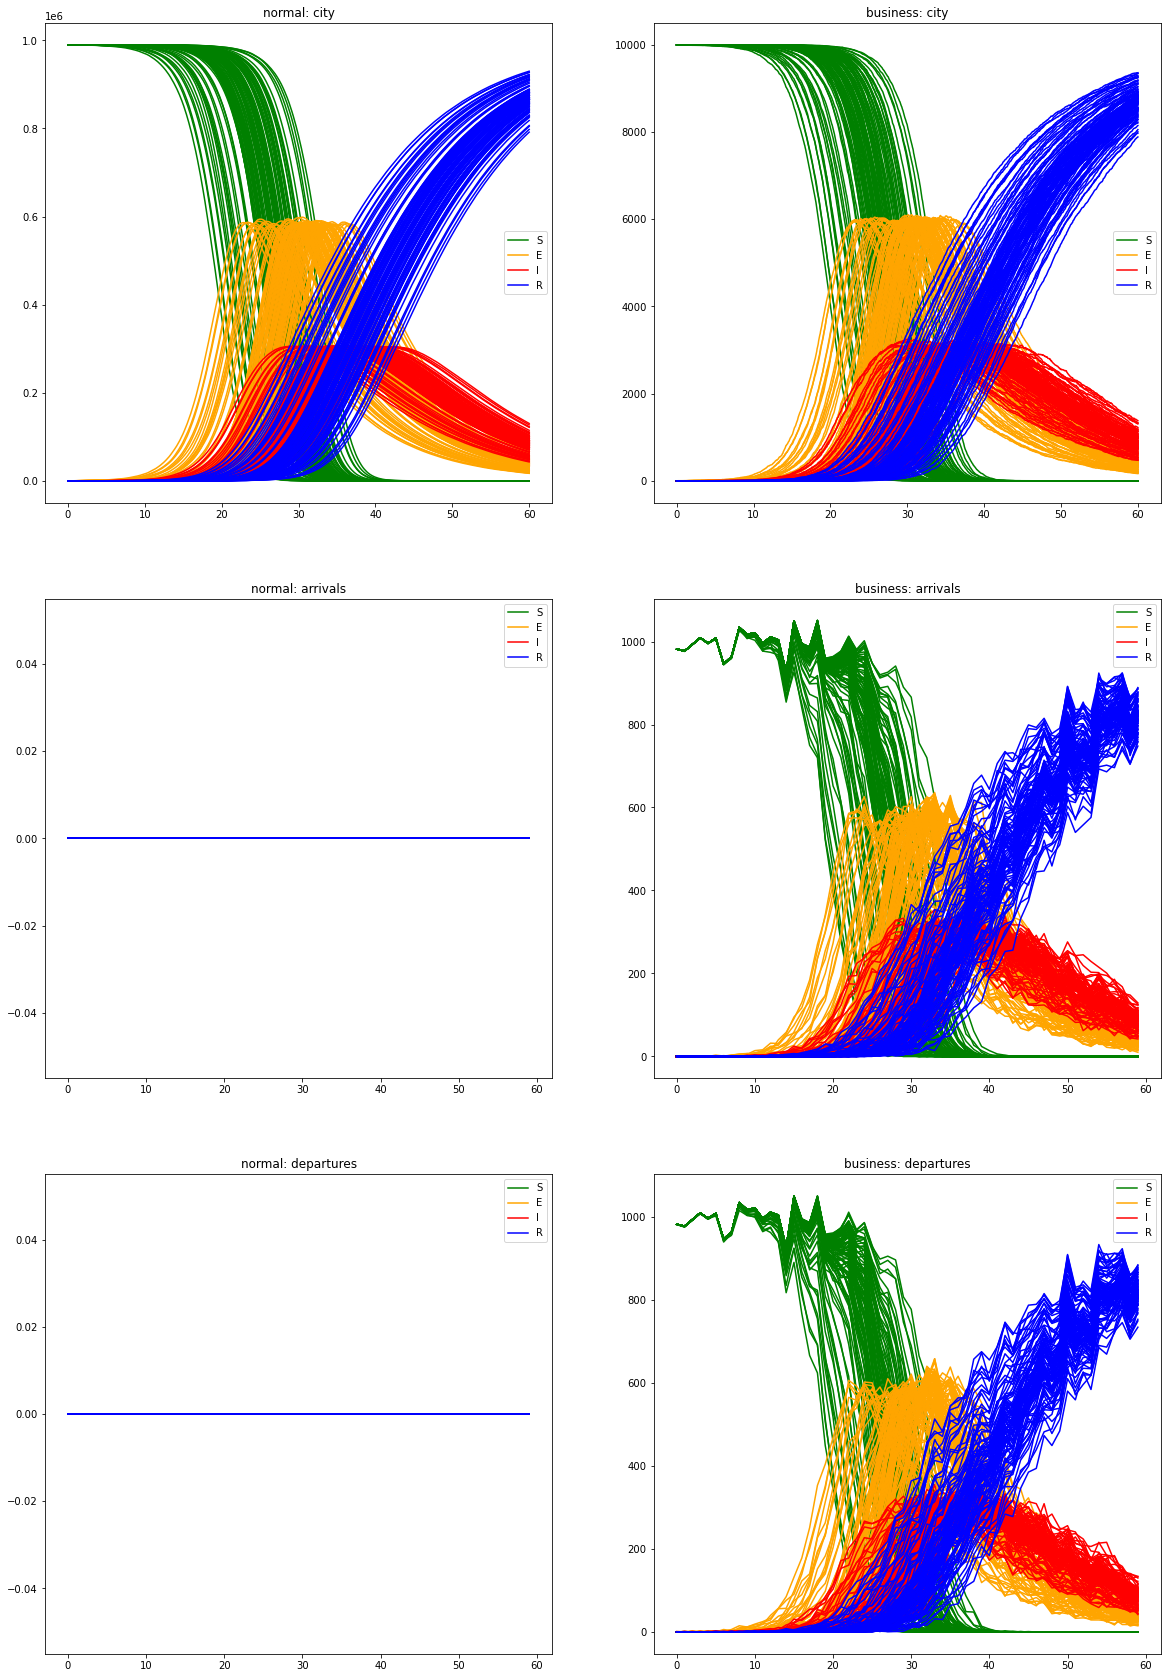

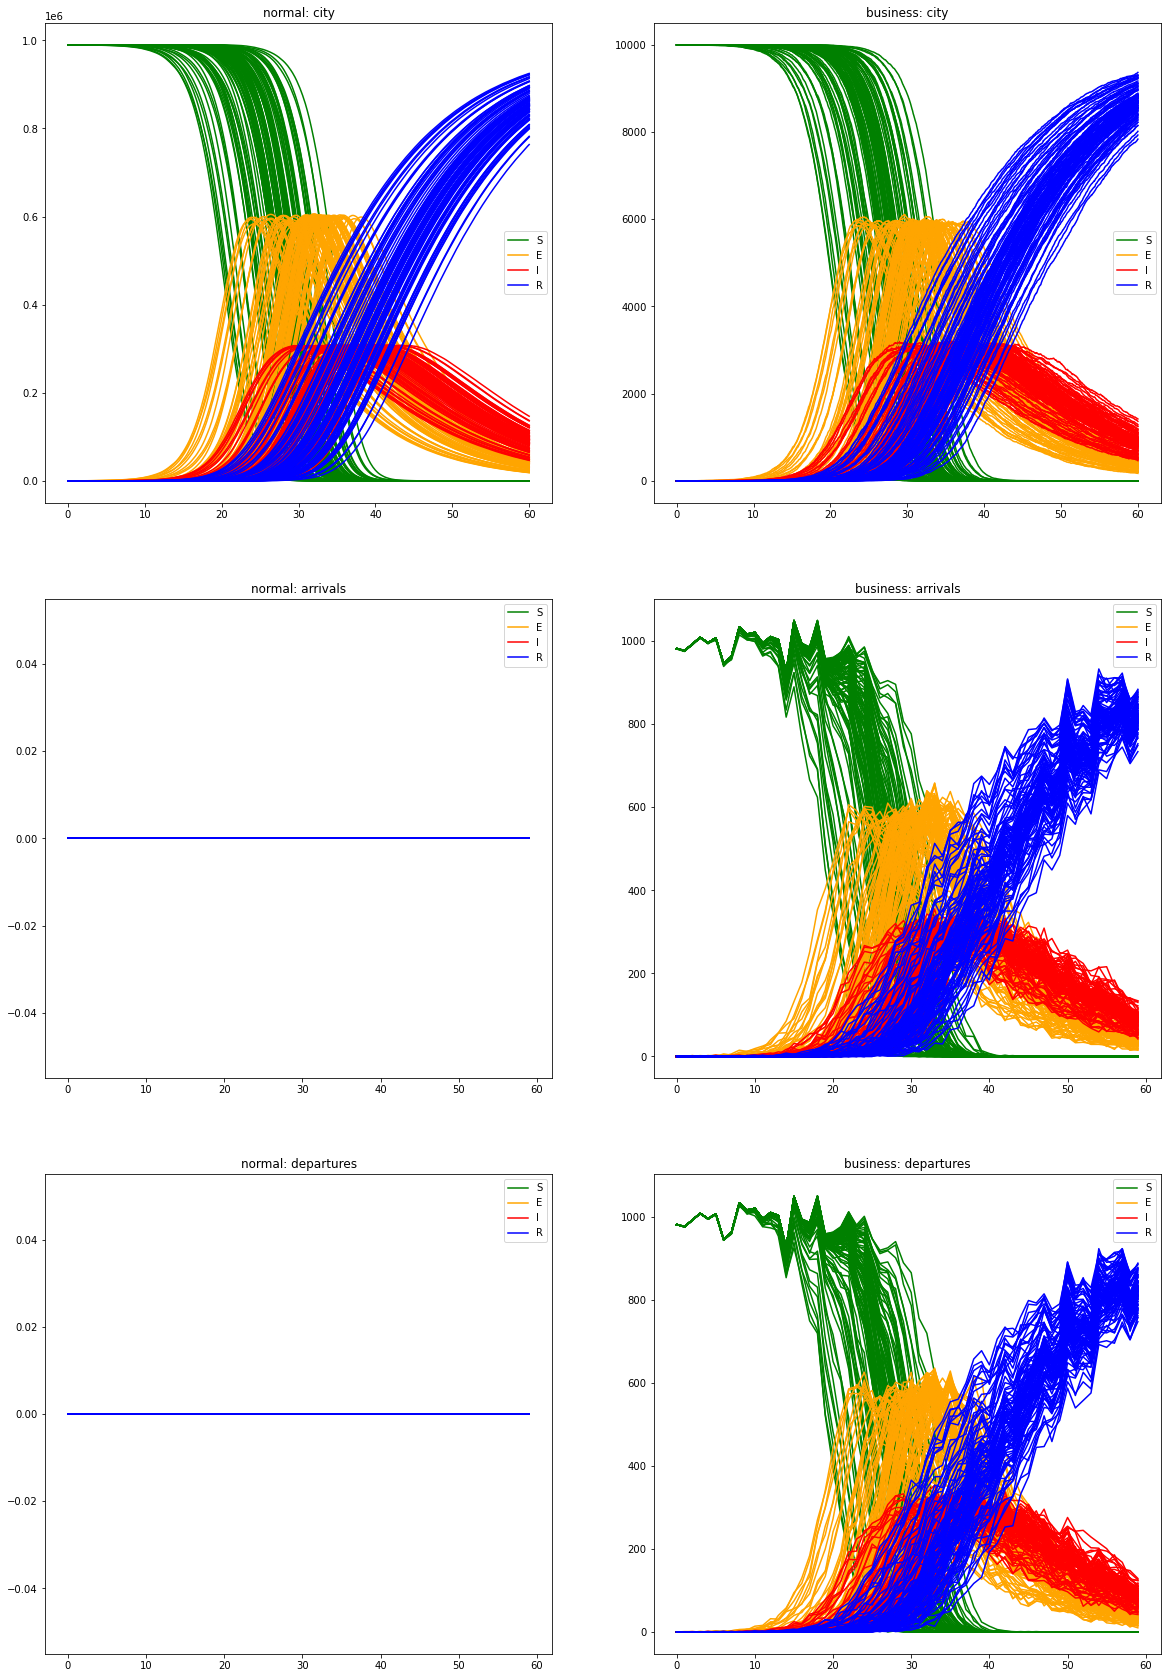

In [22]:
testnetwork.plot_sims()